# SciPy

## What is SciPy

SciPy stands for (Sci)entific (Py)thon. It is an open-source Python library that contains modules for scientific computing such as linear algrbra, optimization, image/signal processing,, statistics, and many more. SciPy uses the NumPy `array` as it's base data struture, but also builds upon `Pandas`, `Matplotlib`, and `SymPy`.

In [1]:
import numpy as np 
import pandas as pd 
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
import matplotlib.pyplot as plt
from scipy import stats 
from scipy import linalg
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

We will be demonstrating SciPy using the Allen Cell Types Dataset. We will discuss what this dataset contains and how to navigate through it in a later chapter. 

In [2]:
# Download meatadata for only human cells 
human_cells = pd.DataFrame(ctc.get_cells(species=[CellTypesApi.HUMAN])).set_index('id')

# Download electrophysiology data 
ephys_df = pd.DataFrame(ctc.get_ephys_features()).set_index('specimen_id')

# Combine our ephys data with our metadata for human cells 
human_ephys_df = human_cells.join(ephys_df)
human_ephys_df.head()

,reporter_status,cell_soma_location,species,name,structure_layer_name,structure_area_id,structure_area_abbrev,transgenic_line,dendrite_type,apical,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
id,,,,,,,,,,,,,,,,,,,,,
525011903,None,"[273.0, 354.0, 216.0]",Homo Sapiens,H16.03.003.01.14.02,3,12113,FroL,,spiny,intact,...,4.134987,1.375253,-53.968754,-59.510420,-71.197919,2.895461,2.559876,3.099787,-88.843758,-70.561035
528642047,None,"[69.0, 254.0, 96.0]",Homo Sapiens,H16.06.009.01.02.06.05,5,12141,MTG,,aspiny,NA,...,NaN,1.051160,-67.468758,NaN,-70.875002,1.891881,NaN,1.989616,-101.000000,-69.209610
537256313,None,"[322.0, 255.0, 92.0]",Homo Sapiens,H16.03.006.01.05.02,4,12141,MTG,,spiny,truncated,...,5.694547,1.389900,-52.125004,-51.520836,-72.900002,3.121182,3.464528,3.054681,-87.531250,-72.628105
519832676,None,"[79.0, 273.0, 91.0]",Homo Sapiens,H16.03.001.01.09.01,3,12141,MTG,,spiny,truncated,...,9.962780,1.211020,-53.875004,-52.416668,-73.693753,4.574865,3.817988,4.980603,-84.218758,-72.547661
596020931,None,"[66.0, 220.0, 105.0]",Homo Sapiens,H17.06.009.11.04.02,4,12141,MTG,,aspiny,NA,...,14.667340,1.336668,-63.593754,-63.239583,-75.518753,1.452890,1.441754,1.556087,-82.531250,-74.260269


## SciPy for two-sample statistics

In [3]:
# Set up our two samples 
spiny_df = human_ephys_df[human_ephys_df['dendrite_type']== 'spiny']
aspiny_df = human_ephys_df[human_ephys_df['dendrite_type']== 'aspiny']

Most often, the goal of our hypothesis testing is to test whether or not two distributions are different, or if a distribution has a different mean than the underlying population distribution.

If we know our distributions are normal (i.e. they're generated from a normal distribution!) we could use parametric statistics to test our hypothesis. To test for differences between normal populations, we can use the independent t-test in our stats package: `stats.ttest_ind()`. If we had paired samples, we would use a dependent t-test: `stats.ttest_rel()`.


If one of our populations is skewed, however, we cannot use a t-test. A t-test assumes that the populations are normally distributed. For skewed populations, we can use either the Mann-Whitney U (for independent samples: `stats.mannwhitneyu()`) or the Wilcoxon Signed Rank Test (for dependent/paired samples: `stats.wilcoxon()`).

Below we will run a statistical test that compares `aspiny_df['tau']` to `spiny_df['tau']`. Before we decide what test to run, we must first check the skewness of our data. To test for skewness, we can use `stats.skewtest()`. **If the skew test gives us a p-value of less than 0.05, the population is skewed.**

Spiny skew test pvalue: 1.4148485388194806e-12
Aspiny skew test pvalue: 1.1827442418538926e-09


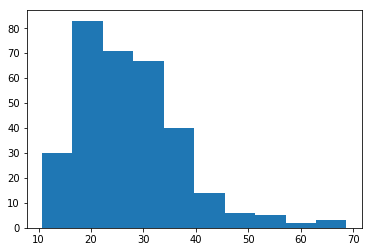

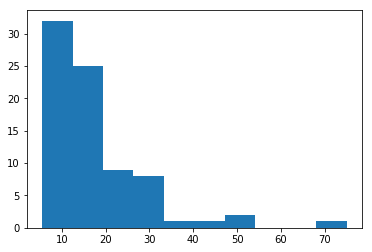

In [4]:
# Subselect our samples 
sample_1 = spiny_df['tau']
sample_2 = aspiny_df['tau']

# Run the skew test
stats_1, pvalue_1 = stats.skewtest(sample_1) 
stats_2, pvalue_2 = stats.skewtest(sample_2)

# Print the p-value of both skew tests
print('Spiny skew test pvalue: ' + str(pvalue_1))
print('Aspiny skew test pvalue: ' + str(pvalue_2))

# Plot our distributions 
plt.hist(sample_1)
plt.show()
plt.hist(sample_2)
plt.show()

Our pvalues indicate that both of our samples are skewed, therefore we will continure with the Mann-Whitney U test. 

In [5]:
print(stats.mannwhitneyu(sample_1, sample_2))

MannwhitneyuResult(statistic=4759.0, pvalue=3.864465154121331e-18)


## SciPy for Linear Algebra

SciPy can be used to find solutions to mathematical algorithms as well. The package has a module with many tools that are helpful with linear algebra. The funtions availabe can help with solving the determinant of a matrix, solve for eigen values, and other liniar algebra problems. After importing the linear algebra module, `linalg` from the SciPy package, it is important to use the syntax `linalg.function()` when executing a function from the module. 

The `linalg.det()` method is used to solve for the the determinant of a matrix. This function only takes in square matrices as an argument, inputting a non-square matrix will result in an error. Please visit <a href = 'https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.det.html'> here</a> for the original documentation. 

In [6]:
# Assign our square matrix
matrix = np.array([[1,3,5,2], [6,3,9,7], [2,7,8,5], [9,4,1,8]])
print(matrix)

[[1 3 5 2]
 [6 3 9 7]
 [2 7 8 5]
 [9 4 1 8]]


In [7]:
print(linalg.det(matrix))

-237.0


The `linalg.lu()` method is used to solve the LU decomposition of a matrix. It will return the  permutation matrix, p, the lower triangular matrix with unit diagonal elements, l,  and the upper triangular, u. You can look at the <a href = 'https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu.html' > SciPy documentation</a> for more information. 

In [8]:
# Assign our matrix 
p, l, u = linalg.lu(matrix)
print('Permutation matrix:')
print(p)
print('\n')
print('Lower triangular:')
print(l)
print('\n')
print('Upper Triangle')
print(u)

Permutation matrix:
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


Lower triangular:
[[1.         0.         0.         0.        ]
 [0.22222222 1.         0.         0.        ]
 [0.66666667 0.05454545 1.         0.        ]
 [0.11111111 0.41818182 0.20689655 1.        ]]


Upper Triangle
[[ 9.          4.          1.          8.        ]
 [ 0.          6.11111111  7.77777778  3.22222222]
 [ 0.          0.          7.90909091  1.49090909]
 [ 0.          0.          0.         -0.54482759]]


Now that we have p, l, and u, we can used a funtion from numpy, `np.dot()` to execute the dot product of l and u to return our matrix. 

In [9]:
print(np.dot(l,u))

[[9. 4. 1. 8.]
 [2. 7. 8. 5.]
 [6. 3. 9. 7.]
 [1. 3. 5. 2.]]


You can also find the eigen values and eigen vectors with SciPy. The method `linalg.eig()` takes in a complex or real matrix and returns its eigenvalues. Please visit the  <a href = 'https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eig.html'> SciPy documentation</a> for more help.

In [10]:
eigen_values, eigen_vectors = linalg.eig(matrix) 
print(eigen_values)
print('\n')
print(eigen_vectors) 

[20.15126564+0.j          1.64808546+0.83387563j  1.64808546-0.83387563j
 -3.44743656+0.j        ]


[[-2.94498514e-01+0.j         -4.63909706e-01+0.08050438j
  -4.63909706e-01-0.08050438j -2.00900213e-04+0.j        ]
 [-5.98355615e-01+0.j         -1.69258696e-01+0.00537595j
  -1.69258696e-01-0.00537595j -8.69603794e-01+0.j        ]
 [-5.83737468e-01+0.j         -2.96214773e-01-0.07015942j
  -2.96214773e-01+0.07015942j  4.14828984e-01+0.j        ]
 [-4.63132542e-01+0.j          8.10533088e-01+0.j
   8.10533088e-01-0.j          2.67779977e-01+0.j        ]]


Lastly, SciPy can be used to solve linear systems of equations. Please visit the  <a href = 'https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html'> SciPy documentation</a> for more help.

In [11]:
array = [[2],[4],[6],[8]]
print(linalg.solve(matrix, array))

[[ 0.04219409]
 [ 0.76793249]
 [-0.31223629]
 [ 0.60759494]]


## SciPy for FFT

Let's first generate a sine wave. We'll then generate a second sine wave and add these together to understand what a fourier transform of this data would look like. Sine waves are defined by their frequency, ampltitude, and and phase. 

In [12]:
sampling_freq = 1024 # Sampling frequency 
duration = 0.3 # 0.3 seconds of signal
freq1 = 7 # 7 Hz signal
freq2 = 130 # 130 Hz signal

# Generate a time vector
time_vector = np.arange(0, duration, 1/sampling_freq)

# Generate a sine wave
signal_1 = np.sin(2 * np.pi * freq1 * time_vector) 
# Generate another sine wave, with double the power
signal_2 = np.sin(2 * np.pi * freq2 * time_vector) * 2 
                                                       
# Add the signals we created above into one signal
combined_signal = signal_1 + signal_2

print('You\'ve created a complex signal with two sin waves, it looks like this:')
print(combined_signal)

You've created a complex signal with two sin waves, it looks like this:
[ 0.          1.47439991  2.08519495  1.48970011  0.07282654 -1.28516247
 -1.73971525 -0.9915122   0.53292413  1.93848187  2.40138863  1.66610567
  0.19943724 -1.09111077 -1.40482347 -0.53084714  1.02457393  2.34344933
  2.64978051  1.77764376  0.27124849 -0.94338912 -1.11709493 -0.12950467
  1.43829796  2.65429147  2.79773083  1.79391154  0.25921309 -0.87075038
 -0.90555508  0.18351981  1.74615215  2.84526973  2.82232648  1.69456043
  0.14458863 -0.89138407 -0.78833049  0.39055267  1.93196998  2.90282491
  2.71311393  1.47185272 -0.07867731 -1.01069639 -0.77059328  0.48712609
  1.99306173  2.82707791  2.47339433  1.13175262 -0.40305218 -1.22060289
 -0.84403858  0.48231033  1.94034552  2.63174967  2.11992873  0.69342222
 -0.80812029 -1.5004171  -0.98795545  0.39745719  1.79689699  2.34251012
  1.68108704  0.18717967 -1.26280101 -1.81923201 -1.17176498  0.26350358
  1.59508858  1.99394982  1.19365596 -0.34884385 -1.

What we have are the signal values for our complex signal composed of the two sin waves. To see our `combined_signal` we must plot it using `plt.plot()`.

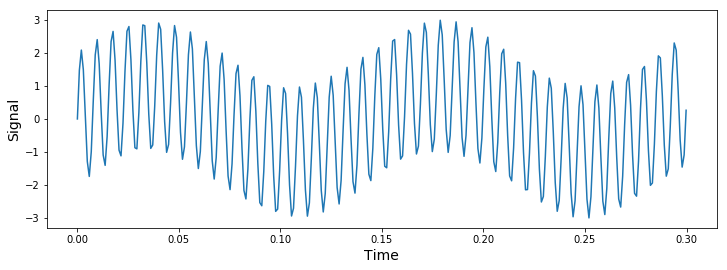

In [13]:
# Set up our figure
fig = plt.figure(figsize=(12, 4))

# Plot 0.5 seconds of data
plt.plot(time_vector, combined_signal) 
plt.ylabel('Signal',fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.show()

In [14]:
# plt.plot(time_vector, signal_1)
# plt.show()
# plt.plot(time_vector, signal_2)
# plt.show()

Below, we'll calculate the **Fourier Transform**, which will determine the frequencies that are in our sample. We'll implement this with Welch's Method, which consists in averaging consecutive Fourier transform of small windows of the signal, with or without overlapping. Basically, we calculate the fourier transform of a signal across a few sliding windows, and then calculate the mean PSD from all the sliding windows.

The freqs vector contains the x-axis (frequency bins) and the psd vector contains the y-axis values (power spectral density). The units of the power spectral density, when working with EEG data, is usually $\mu$V^2 per Hz.

/Users/ashley/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 4096 is greater than input length  = 308, using nperseg = 308
  .format(nperseg, input_length))


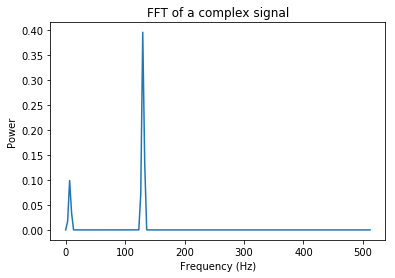

In [15]:
# Import signal processing module 
from scipy import signal

# Define sliding window length (4 seconds, which will give us 2 full cycles at 0.5 Hz)
win = 4 * sampling_freq
freqs, psd = signal.welch(combined_signal, sampling_freq, nperseg=win)

# Plot our data
plt.plot(freqs,psd) # Plot a select range of frequencies
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.title('FFT of a complex signal')
plt.show()

The Fourier Transformation shows us the signal frequencies that make up our combined signal. 

## SciPy for Signal Procesing 

Normal physiological data is never as regular as the data above -- it's usually chock full of lots of different waves, as well as noise. Now that we have a sense of the tools we need, let's work with some real data.

The data we'll import here is a real 30-seconds extract of slow-wave sleep from a young individual, collected by the Walker Lab at UC Berkeley. This data was collected at 100 Hz from channel 'F3'. This sampling frequency is fine for EEG data, but wouldn't be enough for high frequency spiking data. That kind of data is typically sampled at 40 kHz.

In [16]:
import urllib.request

# URL of data to download
data_url = 'https://raphaelvallat.com/images/tutorials/bandpower/data.txt'

# Get the data and save it locally as "sleep_data.txt"
sleep_data, headers = urllib.request.urlretrieve(data_url, './sleep_data.txt')

# Load the .txt file as a numpy array
data = np.loadtxt('sleep_data.txt')

Now that we have the data, let's took a look at the raw signal.

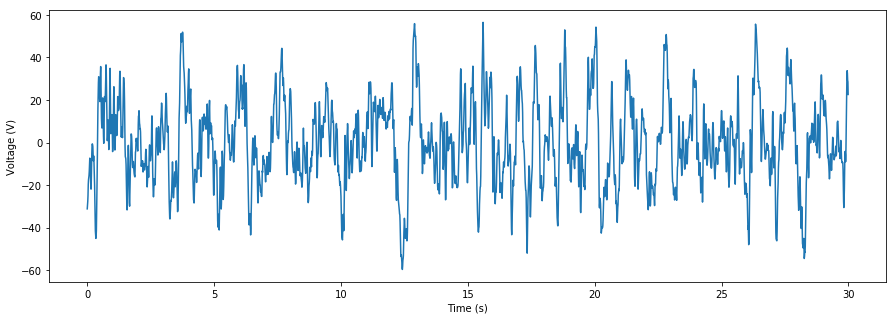

In [17]:
sampling_freq = 100

time_vector = np.arange(0,30,1/sampling_freq)
fig = plt.figure(figsize=(15,5))
plt.plot(time_vector,data)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()

In this real EEG data, the underlying frequencies are much harder to see by eye. So, we'll compute a bandpass by first applying a low-pass filter_, followed by a _high-pass filter (or vice versa).

Signal filtration is usually accomplished in 2 steps
1. Design a _filter kernel_
2. Apply the filter kernel to the data
    
We will use a **Butterworth** filter. The ideal filter would _completely_ pass everything in the passband (i.e., allow through the parts of the signal we care about) and completely reject everything outside of it, but this cannot be achieved in reality—the Butterworth filter is a close approximation.

We design the filter in Python using `scipy`'s `signal.butter` function, with three arguments:
1. The _filter order_ : (we'll use a 4th order filter)
2. The _filter frequency_ : (we must adjust for the sampling frequency, `f_s`, which is 100 Hz for these data, i.e. 100 data points were recorded per second)
3. The type of filter : (`'lowpass'` or `'highpass'`)

It returns 2 filter parameters, `a` and `b`. Then, the bandpass filter is applied using `signal.filtfilt`, which takes as its parameters `b`, `a`, and the signal to be processed

Below, an example bandpass computation is shown to extract the _alpha_ rhythm from the channel 1 data, the results are stored in a dictionary called `oscillations_filtered`, with the oscillation name (e.g. `'alpha'`) as the key

In [18]:
# Define lower and upper limits of our bandpass
filter_limits = [0.5, 4]

# First, apply a lowpass filter
# Design filter with high filter limit
b, a = signal.butter(4, (filter_limits[1]/ (sampling_freq / 2)), 'lowpass') 

# Apply it forwards and backwards (filtfilt)
lowpassed = signal.filtfilt(b, a, data)

# Then, apply a high pass filter
# Design filter with low filter limit
b, a = signal.butter(4, (filter_limits[0] / (sampling_freq / 2)), 'highpass') 

# Apply it
bandpassed = signal.filtfilt(b, a, lowpassed) 

Now lets plot our bandpassed data.

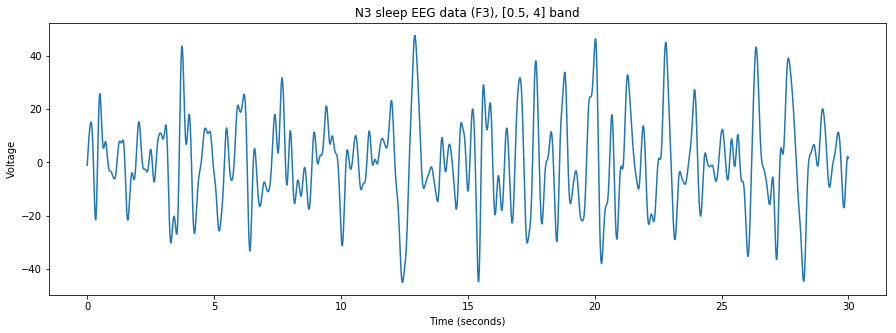

In [19]:
# Plot the bandpassed data
fig = plt.figure(figsize=(15,5))
plt.plot(time_vector,bandpassed)
plt.ylabel('Voltage')

# Let's programmatically set the title here, using {} format
plt.title('N3 sleep EEG data (F3), {} band' .format(filter_limits))

plt.xlabel('Time (seconds)')
plt.show()

## Additional Resources